In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

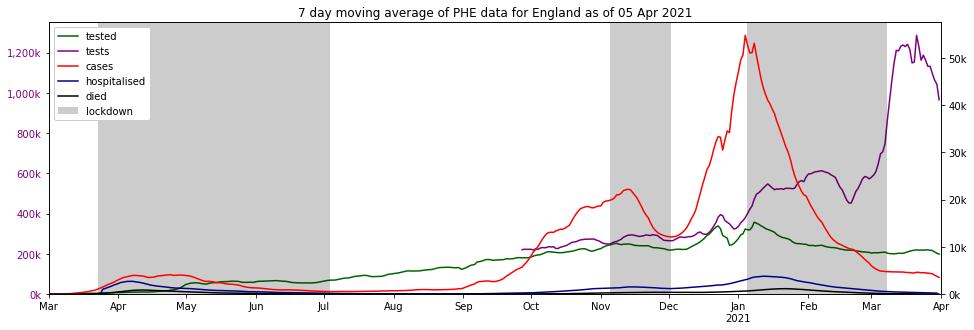

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

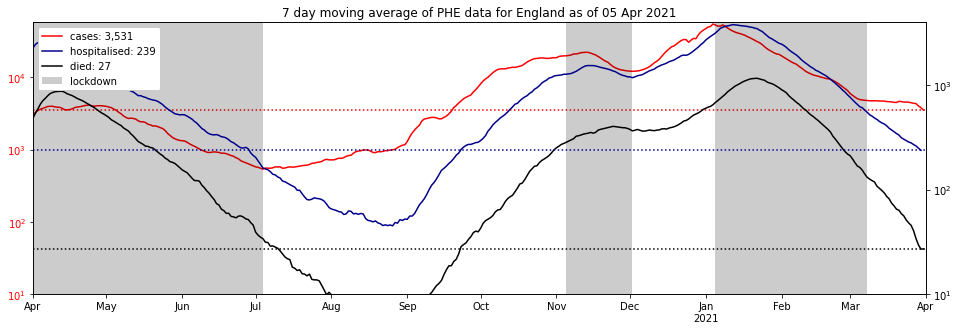

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

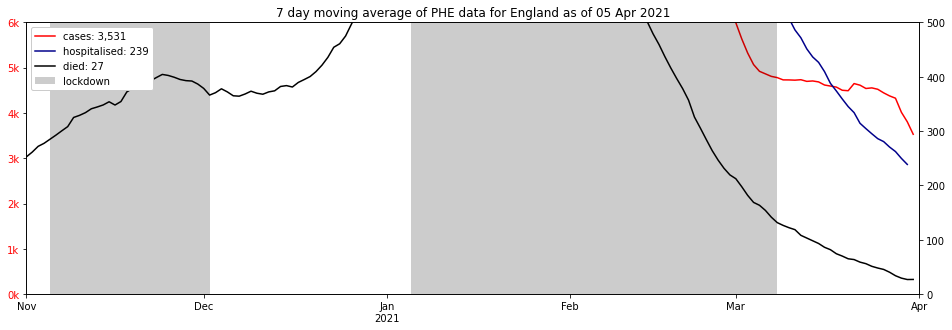

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=6_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

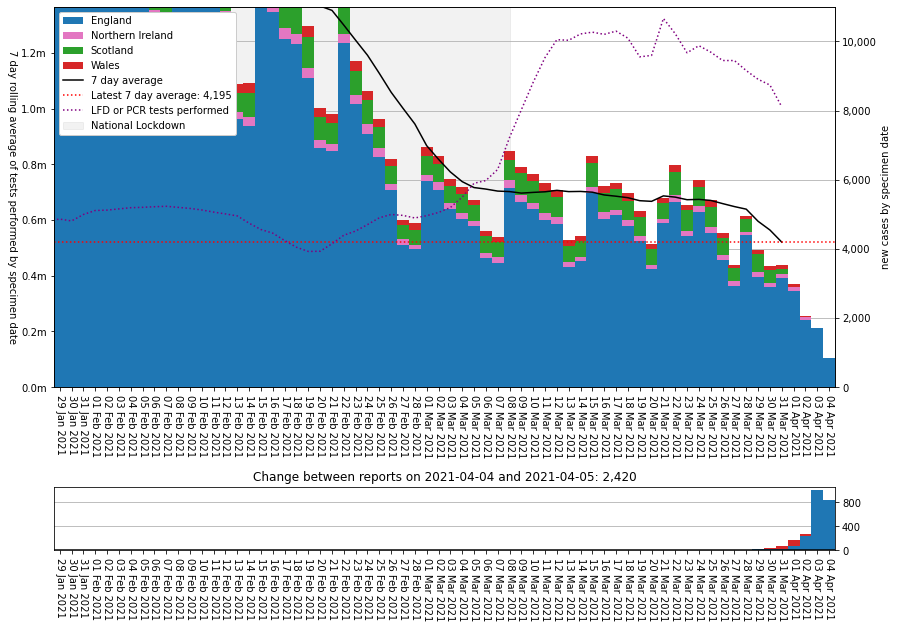

In [5]:
plot_areas(for_date, 'cases_nations', ylim=11_000, earliest='2021-01-29')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,4344251.0,26746039.0,22401788.0,56286961,7.718041,39.799249,52.482709
1,Northern Ireland,N92000002,163818.0,779932.0,616114.0,1893667,8.650835,32.535499,58.813667
2,Scotland,S92000003,456374.0,2565280.0,2108906.0,5463300,8.353449,38.601322,53.045229
3,Wales,W92000004,467683.0,1490372.0,1022689.0,3152879,14.833522,32.436671,52.729807


'partial: 31,581,623 (47.3%), full: 5,432,126'

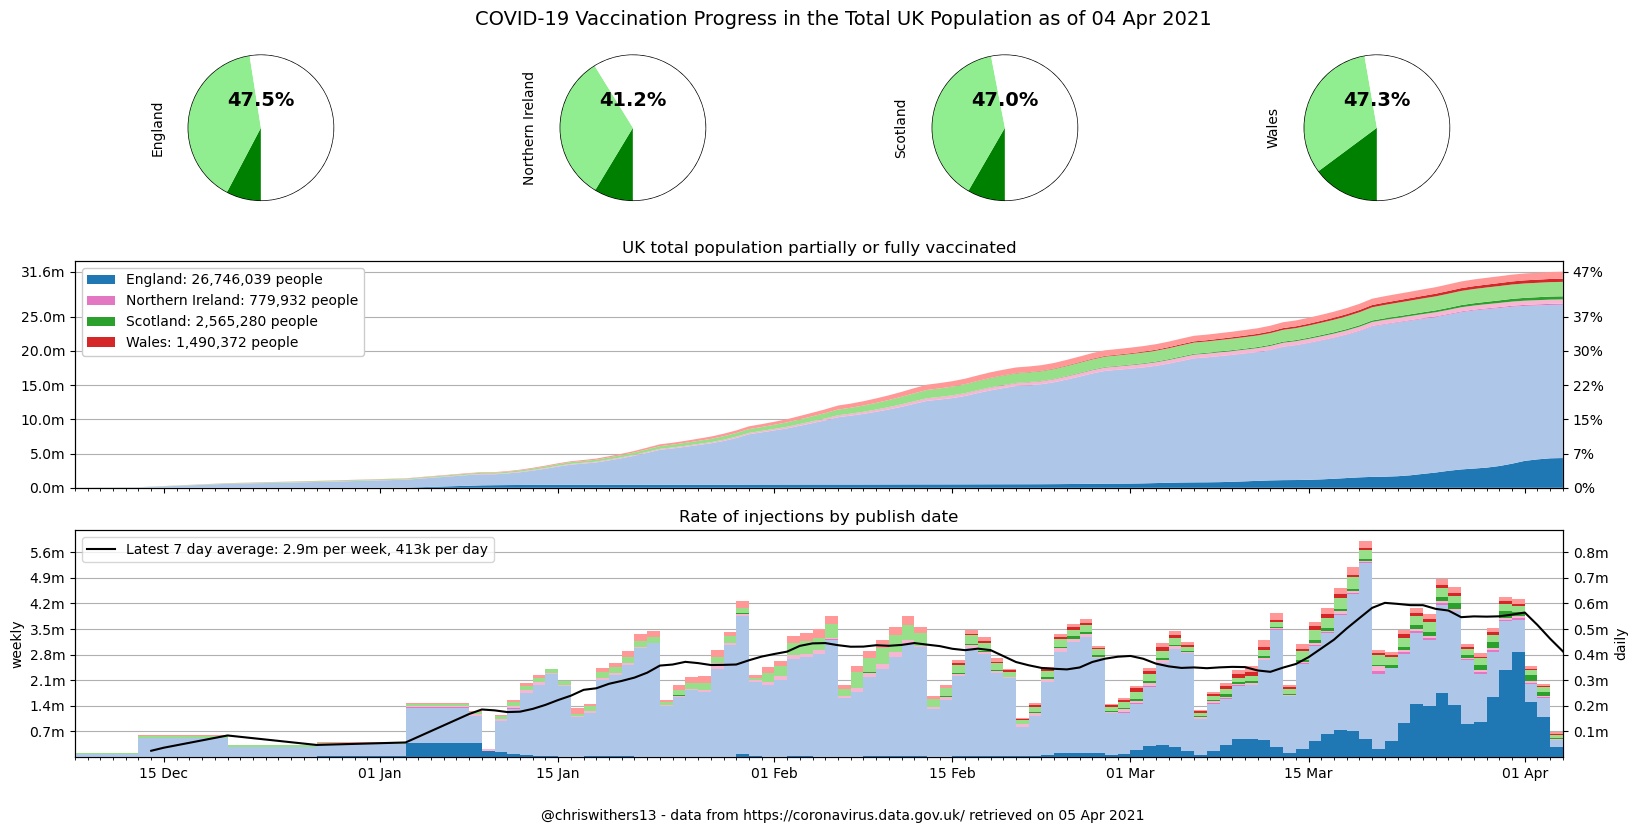

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

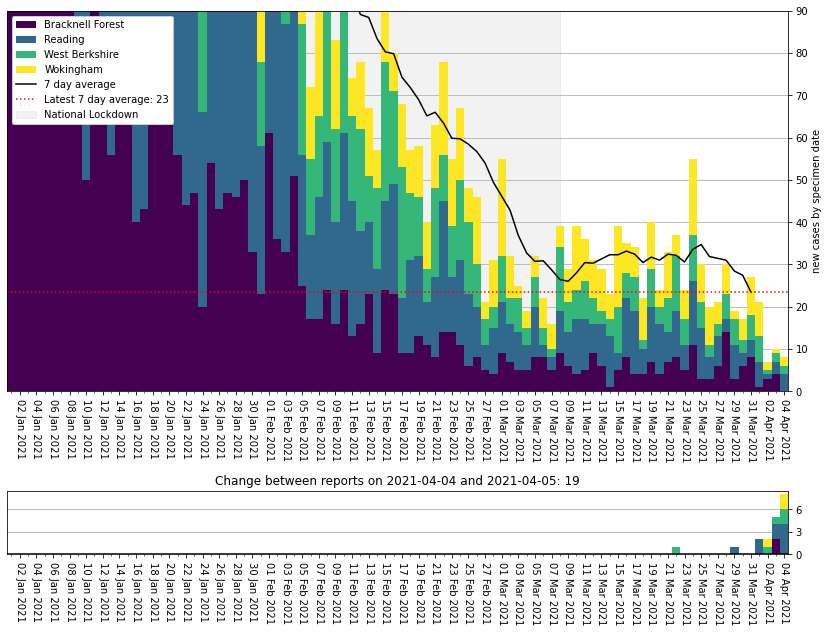

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2021-01-01', ylim=90)

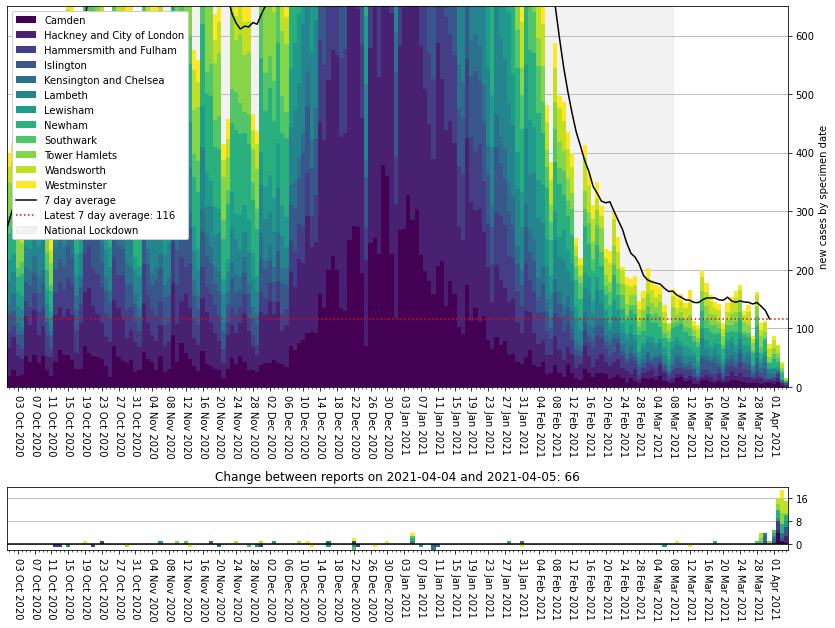

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,120.468581,87.0,2021-04-04
S12000005,Clackmannanshire,108.653473,56.0,2021-03-31
E08000016,Barnsley,98.028890,242.0,2021-04-04
E08000036,Wakefield,93.307150,325.0,2021-04-04
E07000174,Mansfield,85.991602,94.0,2021-04-04
E06000032,Luton,80.262096,171.0,2021-04-04
E06000016,Leicester,80.175256,284.0,2021-04-04
E08000017,Doncaster,78.553336,245.0,2021-04-04
E06000010,"Kingston upon Hull, City of",77.373758,201.0,2021-04-04


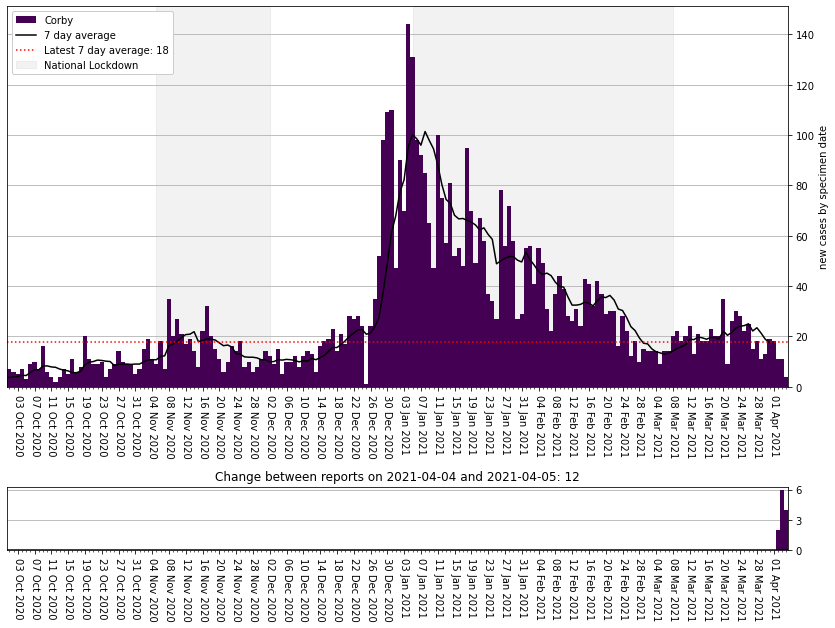

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,73.631482,584.0,2021-04-04
E08000019,Sheffield,72.838816,426.0,2021-04-04
E08000025,Birmingham,34.068536,389.0,2021-04-04
E08000032,Bradford,69.473263,375.0,2021-04-04
E08000036,Wakefield,93.307150,325.0,2021-04-04
E08000003,Manchester,57.519291,318.0,2021-04-04
E06000016,Leicester,80.175256,284.0,2021-04-04
E08000034,Kirklees,62.985036,277.0,2021-04-04
E08000017,Doncaster,78.553336,245.0,2021-04-04


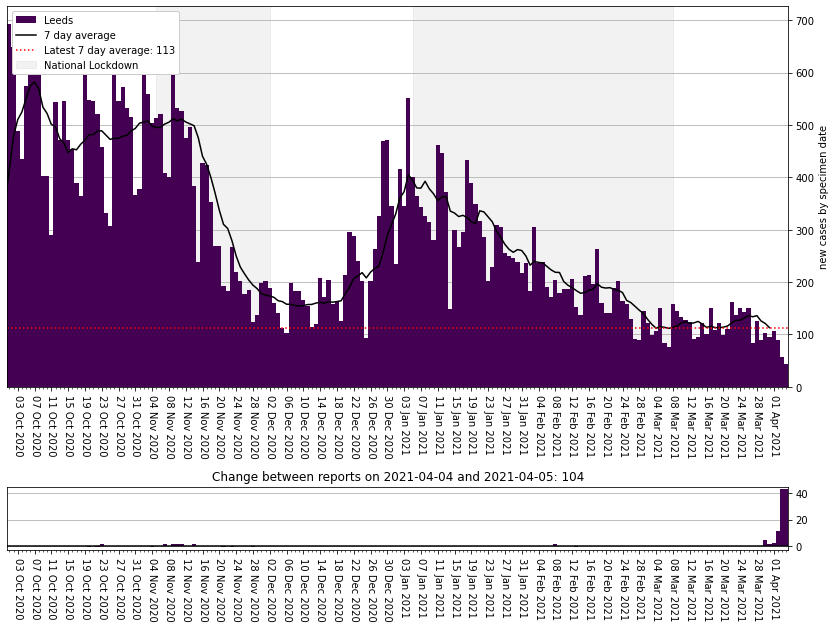

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [18]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.5
phe_max = 0.18

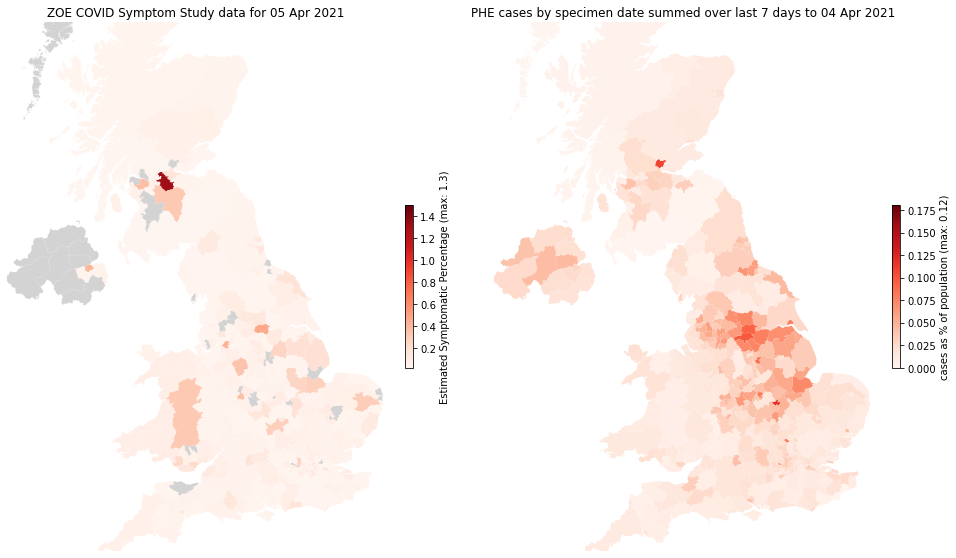

In [19]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [20]:


bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...